D =  [ 1.          0.99935246  0.99870492 ...,  0.01183251  0.01118497
  0.01053744]
D =  [ 1.          0.99935216  0.99870431 ...,  0.00957946  0.00893162
  0.00828377]
D =  [ 1.          0.99935185  0.99870371 ...,  0.00731729  0.00666914
  0.00602099]
D =  [ 1.          0.99935155  0.9987031  ...,  0.00504591  0.00439746
  0.00374901]
D =  [ 1.          0.99935124  0.99870249 ...,  0.00276524  0.00211648
  0.00146773]
D =  [  1.00000000e+00   9.99350938e-01   9.98701875e-01 ...,   1.76756416e-03
   1.11850202e-03   4.69439759e-04]
D =  [  1.00000000e+00   9.99350633e-01   9.98701266e-01 ...,   2.06960043e-03
   1.42023343e-03   7.70866268e-04]
D =  [ 1.          0.99935033  0.99870066 ...,  0.00236388  0.0017142
  0.00106453]
D =  [  1.00000000e+00   9.99350023e-01   9.98700046e-01 ...,   1.34911815e-03
   6.99141167e-04   4.91641098e-05]
catch kcrit =  1.03436718359


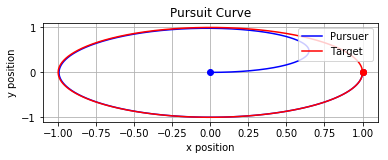

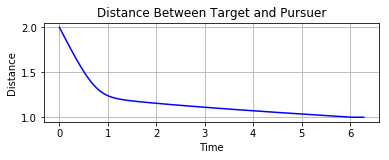

0:00:02.663308


In [11]:
# 2*pi

from datetime import datetime
startTime = datetime.now()
import numpy as np
import matplotlib.pyplot as plt
import sys
import random
import operator
from pyspark import SparkConf, SparkContext

#conf = SparkConf().setAppName("euler")
#sc = SparkContext(conf=conf)
assert sc.version >= '1.5.1'

def ForwardEuler(deltaT, P0, k, Tprime_rdd, Tarray_rdd):     
    x = np.zeros(N)
    y = np.zeros(N)
    x[0] = P0[0]
    y[0] = P0[1]

    for i in range(N-1):
        x[i+1] = x[i] + deltaT*(((k*np.sqrt((Tprime_rdd[i][0][0])**2 + (Tprime_rdd[i][0][1])**2))/ np.sqrt((Tarray_rdd[i][0][0]-x[i])**2 + (Tarray_rdd[i][0][1]-y[i])**2)) * (Tarray_rdd[i][0][0]-x[i]))
        TprimeNorm = k*np.sqrt((Tprime_rdd[i][0][0])**2 + (Tprime_rdd[i][0][1])**2)
        b = np.sqrt((Tarray_rdd[i][0][0]-x[i])**2 + (Tarray_rdd[i][0][1]-y[i])**2)
        y[i+1] = y[i] + deltaT*((TprimeNorm/b)*(Tarray_rdd[i][0][1]-y[i]))
        
    P = np.vstack((x,y)) 
    return (t, P) 

def T(t):
    Tx = np.cos(t) 
    Ty = np.sin(t)  
    return np.array([Tx, Ty]) 


def Tprime(t):   
    First = T(t+0.000001)
    Second = T(t)
    Tp = (First-Second)/0.000001
    return Tp


def Plot(PX, PY, Tx1, Ty1, Distance, tFE):
#Part b: Pursuit Curve
    plt.figure(1)
    plt.subplot(211)
    plt.plot(PX, PY, 'b', label='Pursuer')  
    plt.plot(PX[0], PY[0], 'bo-', PX[-1], PY[-1], 'bo-')    
    plt.plot(Tx1, Ty1, 'r', label='Target')  
    plt.plot(Tx1[0], Ty1[0], 'ro-', Tx1[-1], Ty1[-1], 'ro-')
    plt.title("Pursuit Curve")
    plt.xlabel('x position')
    plt.ylabel('y position')     
    plt.legend(loc=1)
    plt.grid()
    plt.show()

#Part c: Distance between
    plt.subplot(212)
    plt.plot(tFE, Distance, 'b')
    plt.title("Distance Between Target and Pursuer")
    plt.xlabel('Time')
    plt.ylabel('Distance')     
    plt.legend(loc=1)
    plt.grid()
    plt.show()

    
def FindK(tCatch, kInitialGuess, kUpperLimit, Distance):
    (k, deltaK) = np.linspace(kInitialGuess, kUpperLimit, 2000, retstep=True)
    k0 = k[0]
    Distance += 1    #Changes distance to force to recalculate k even if k from Part one works (used to optimize)
    while 10**(-4) <= Distance[-1]:  
        k0 += deltaK
        (TempT, TempY) = ForwardEuler(deltaT, P0, k0, Tprime_rdd[:][:][:], Tarray_rdd[:][:][:])
        PXtemp = TempY[0]
        PYtemp = TempY[1]
        Tpos = T(tCatch)
        Tx2 = Tpos[0]
        Ty2 = Tpos[1]
        Distance = np.sqrt((Tx2-PXtemp)**2 + (Ty2-PYtemp)**2)
        print('D = ',Distance)
    return k0

#Initial Conditions
P0 = [0, 0]
k = 1.03436718359       #use for part 1
tEnd = np.pi*2           #Also tCatch for part 2
N = 10000

Tx1 = np.zeros(N)
Ty1 = np.zeros(N)
tCopy = np.linspace(0, tEnd, N)
tCopy_rdd = sc.parallelize(tCopy)

kInitialGuess = 1.03        #initial guess to cut down waiting time for part 2
kUpperLimit = 2             #Increase as needed if k never reaches less than 10^(-4)


#Calculate Target's position for plotting
Tpos = tCopy_rdd.map(T)
T_rdd = Tpos.zipWithIndex().collect()
for j in range (N):
    Tx1[j] = T_rdd[j][0][0]
    Ty1[j] = T_rdd[j][0][1]
    Target = np.vstack((Tx1,Ty1))
    #print(Tx1,Ty1)

    
(t, deltaT) = np.linspace(0, tEnd, N, retstep=True)
t_rdd = sc.parallelize(t)
Tarray = t_rdd.map(T)
Tarray_rdd = Tarray.zipWithIndex().collect()
TprimeArray = t_rdd.map(Tprime)
Tprime_rdd = TprimeArray.zipWithIndex().collect()


#Calculate Forward Euler
(tFE, yFE) = ForwardEuler(deltaT, P0, k, Tprime_rdd[:][:][:], Tarray_rdd[:][:][:])

PX = yFE[0]
PY = yFE[1]

#Calculate distance between Target and Pursuer
Distance = np.sqrt((Tx1-PX)**2 + (Ty1-PY)**2)

#Find Kcrit
k = FindK(tEnd, kInitialGuess, kUpperLimit, Distance)
print('catch kcrit = ',k)

#Plot Pursuit and Distance graphs
Plot(PX, PY, Tx1, Ty1, Distance, tFE)
print(datetime.now() - startTime)

D =  [ 1.          1.00095246  1.00190493 ...,  0.05632689  0.05537443
  0.05442196]
D =  [ 1.          1.00095293  1.00190586 ...,  0.05335871  0.05240578
  0.05145285]
D =  [ 1.          1.0009534   1.0019068  ...,  0.05036726  0.04941386
  0.04846046]
D =  [ 1.          1.00095387  1.00190773 ...,  0.04735215  0.04639829
  0.04544442]
D =  [ 1.          1.00095433  1.00190866 ...,  0.04431302  0.04335869
  0.04240436]
D =  [ 1.          1.0009548   1.0019096  ...,  0.04124947  0.04029467
  0.03933987]
D =  [ 1.          1.00095527  1.00191053 ...,  0.03816109  0.03720582
  0.03625056]
D =  [ 1.          1.00095573  1.00191146 ...,  0.03504747  0.03409174
  0.03313601]
D =  [ 1.         1.0009562  1.0019124 ...,  0.0319082  0.030952   0.0299958]
D =  [ 1.          1.00095667  1.00191333 ...,  0.02874283  0.02778617
  0.0268295 ]
D =  [ 1.          1.00095713  1.00191426 ...,  0.02555091  0.02459378
  0.02363665]
D =  [ 1.         1.0009576  1.0019152 ...,  0.022332   0.0213744  0.020

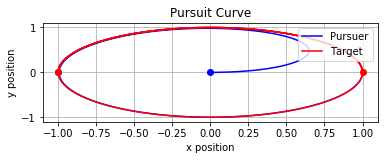

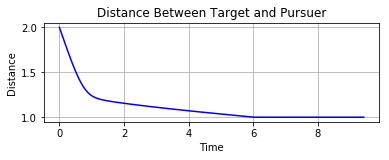

0:00:03.808821


In [17]:
# 3*pi

from datetime import datetime
startTime = datetime.now()
import numpy as np
import matplotlib.pyplot as plt
import sys
import random
import operator
from pyspark import SparkConf, SparkContext

#conf = SparkConf().setAppName("euler")
#sc = SparkContext(conf=conf)
assert sc.version >= '1.5.1'

def ForwardEuler(deltaT, P0, k, Tprime_rdd, Tarray_rdd):     
    x = np.zeros(N)
    y = np.zeros(N)
    x[0] = P0[0]
    y[0] = P0[1]

    for i in range(N-1):
        x[i+1] = x[i] + deltaT*(((k*np.sqrt((Tprime_rdd[i][0][0])**2 + (Tprime_rdd[i][0][1])**2))/ np.sqrt((Tarray_rdd[i][0][0]-x[i])**2 + (Tarray_rdd[i][0][1]-y[i])**2)) * (Tarray_rdd[i][0][0]-x[i]))
        TprimeNorm = k*np.sqrt((Tprime_rdd[i][0][0])**2 + (Tprime_rdd[i][0][1])**2)
        b = np.sqrt((Tarray_rdd[i][0][0]-x[i])**2 + (Tarray_rdd[i][0][1]-y[i])**2)
        y[i+1] = y[i] + deltaT*((TprimeNorm/b)*(Tarray_rdd[i][0][1]-y[i]))
        
    P = np.vstack((x,y)) 
    return (t, P) 

def T(t):
    Tx = np.cos(t) 
    Ty = np.sin(t)  
    return np.array([Tx, Ty]) 


def Tprime(t):   
    First = T(t+0.000001)
    Second = T(t)
    Tp = (First-Second)/0.000001
    return Tp


def Plot(PX, PY, Tx1, Ty1, Distance, tFE):
#Part b: Pursuit Curve
    plt.figure(1)
    plt.subplot(211)
    plt.plot(PX, PY, 'b', label='Pursuer')  
    plt.plot(PX[0], PY[0], 'bo-', PX[-1], PY[-1], 'bo-')    
    plt.plot(Tx1, Ty1, 'r', label='Target')  
    plt.plot(Tx1[0], Ty1[0], 'ro-', Tx1[-1], Ty1[-1], 'ro-')
    plt.title("Pursuit Curve")
    plt.xlabel('x position')
    plt.ylabel('y position')     
    plt.legend(loc=1)
    plt.grid()
    plt.show()

#Part c: Distance between
    plt.subplot(212)
    plt.plot(tFE, Distance, 'b')
    plt.title("Distance Between Target and Pursuer")
    plt.xlabel('Time')
    plt.ylabel('Distance')     
    plt.legend(loc=1)
    plt.grid()
    plt.show()

    
def FindK(tCatch, kInitialGuess, kUpperLimit, Distance):
    (k, deltaK) = np.linspace(kInitialGuess, kUpperLimit, 2000, retstep=True)
    k0 = k[0]
    Distance += 1    #Changes distance to force to recalculate k even if k from Part one works (used to optimize)
    while 10**(-4) <= Distance[-1]:  
        k0 += deltaK
        (TempT, TempY) = ForwardEuler(deltaT, P0, k0, Tprime_rdd[:][:][:], Tarray_rdd[:][:][:])
        PXtemp = TempY[0]
        PYtemp = TempY[1]
        Tpos = T(tCatch)
        Tx2 = Tpos[0]
        Ty2 = Tpos[1]
        Distance = np.sqrt((Tx2-PXtemp)**2 + (Ty2-PYtemp)**2)
        print('D = ',Distance)
    return k0

#Initial Conditions
P0 = [0, 0]
k = 1.03436718359       #use for part 1
tEnd = np.pi*3           #Also tCatch for part 2
N = 10000

Tx1 = np.zeros(N)
Ty1 = np.zeros(N)
tCopy = np.linspace(0, tEnd, N)
tCopy_rdd = sc.parallelize(tCopy)

kInitialGuess = 1.01        #initial guess to cut down waiting time for part 2
kUpperLimit = 2             #Increase as needed if k never reaches less than 10^(-4)


#Calculate Target's position for plotting
Tpos = tCopy_rdd.map(T)
T_rdd = Tpos.zipWithIndex().collect()
for j in range (N):
    Tx1[j] = T_rdd[j][0][0]
    Ty1[j] = T_rdd[j][0][1]
    Target = np.vstack((Tx1,Ty1))
    #print(Tx1,Ty1)

    
(t, deltaT) = np.linspace(0, tEnd, N, retstep=True)
t_rdd = sc.parallelize(t)
Tarray = t_rdd.map(T)
Tarray_rdd = Tarray.zipWithIndex().collect()
TprimeArray = t_rdd.map(Tprime)
Tprime_rdd = TprimeArray.zipWithIndex().collect()


#Calculate Forward Euler
(tFE, yFE) = ForwardEuler(deltaT, P0, k, Tprime_rdd[:][:][:], Tarray_rdd[:][:][:])

PX = yFE[0]
PY = yFE[1]

#Calculate distance between Target and Pursuer
Distance = np.sqrt((Tx1-PX)**2 + (Ty1-PY)**2)

#Find Kcrit
k = FindK(tEnd, kInitialGuess, kUpperLimit, Distance)
print('catch kcrit = ',k)

#Plot Pursuit and Distance graphs
Plot(PX, PY, Tx1, Ty1, Distance, tFE)
print(datetime.now() - startTime)

D =  [ 1.          1.00033947  1.00067894 ...,  0.00515569  0.00481622
  0.00447675]
D =  [ 1.          1.00033962  1.00067923 ...,  0.00409413  0.00375452
  0.0034149 ]
D =  [ 1.          1.00033976  1.00067952 ...,  0.00303143  0.00269167
  0.00235191]
D =  [ 1.          1.0003399   1.00067981 ...,  0.00196758  0.00162768
  0.00128778]
D =  [  1.00000000e+00   1.00034005e+00   1.00068010e+00 ...,   9.02583608e-04
   5.62534693e-04   2.22485762e-04]
D =  [  1.00000000e+00   1.00034019e+00   1.00068039e+00 ...,   1.19720337e-03
   8.57009861e-04   5.16816333e-04]
D =  [  1.00000000e+00   1.00034034e+00   1.00068068e+00 ...,   8.11159678e-04
   4.70821557e-04   1.30483424e-04]
D =  [  1.00000000e+00   1.00034048e+00   1.00068097e+00 ...,   1.10552854e-03
   7.65045836e-04   4.24563108e-04]
D =  [  1.00000000e+00   1.00034063e+00   1.00068125e+00 ...,   7.18680860e-04
   3.78053533e-04   3.74261960e-05]
catch kcrit =  1.08414207104


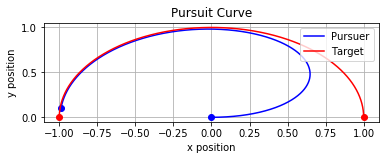

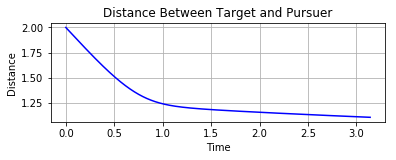

0:00:02.718467


In [6]:
# pi

from datetime import datetime
startTime = datetime.now()
import numpy as np
import matplotlib.pyplot as plt
import sys
import random
import operator
from pyspark import SparkConf, SparkContext

#conf = SparkConf().setAppName("euler")
#sc = SparkContext(conf=conf)
assert sc.version >= '1.5.1'

def ForwardEuler(deltaT, P0, k, Tprime_rdd, Tarray_rdd):     
    x = np.zeros(N)
    y = np.zeros(N)
    x[0] = P0[0]
    y[0] = P0[1]

    for i in range(N-1):
        x[i+1] = x[i] + deltaT*(((k*np.sqrt((Tprime_rdd[i][0][0])**2 + (Tprime_rdd[i][0][1])**2))/ np.sqrt((Tarray_rdd[i][0][0]-x[i])**2 + (Tarray_rdd[i][0][1]-y[i])**2)) * (Tarray_rdd[i][0][0]-x[i]))
        TprimeNorm = k*np.sqrt((Tprime_rdd[i][0][0])**2 + (Tprime_rdd[i][0][1])**2)
        b = np.sqrt((Tarray_rdd[i][0][0]-x[i])**2 + (Tarray_rdd[i][0][1]-y[i])**2)
        y[i+1] = y[i] + deltaT*((TprimeNorm/b)*(Tarray_rdd[i][0][1]-y[i]))
        
    P = np.vstack((x,y)) 
    return (t, P) 

def T(t):
    Tx = np.cos(t) 
    Ty = np.sin(t)  
    return np.array([Tx, Ty]) 


def Tprime(t):   
    First = T(t+0.000001)
    Second = T(t)
    Tp = (First-Second)/0.000001
    return Tp


def Plot(PX, PY, Tx1, Ty1, Distance, tFE):
#Part b: Pursuit Curve
    plt.figure(1)
    plt.subplot(211)
    plt.plot(PX, PY, 'b', label='Pursuer')  
    plt.plot(PX[0], PY[0], 'bo-', PX[-1], PY[-1], 'bo-')    
    plt.plot(Tx1, Ty1, 'r', label='Target')  
    plt.plot(Tx1[0], Ty1[0], 'ro-', Tx1[-1], Ty1[-1], 'ro-')
    plt.title("Pursuit Curve")
    plt.xlabel('x position')
    plt.ylabel('y position')     
    plt.legend(loc=1)
    plt.grid()
    plt.show()

#Part c: Distance between
    plt.subplot(212)
    plt.plot(tFE, Distance, 'b')
    plt.title("Distance Between Target and Pursuer")
    plt.xlabel('Time')
    plt.ylabel('Distance')     
    plt.legend(loc=1)
    plt.grid()
    plt.show()

    
def FindK(tCatch, kInitialGuess, kUpperLimit, Distance):
    (k, deltaK) = np.linspace(kInitialGuess, kUpperLimit, 2000, retstep=True)
    k0 = k[0]
    Distance += 1    #Changes distance to force to recalculate k even if k from Part one works (used to optimize)
    while 10**(-4) <= Distance[-1]:  
        k0 += deltaK
        (TempT, TempY) = ForwardEuler(deltaT, P0, k0, Tprime_rdd[:][:][:], Tarray_rdd[:][:][:])
        PXtemp = TempY[0]
        PYtemp = TempY[1]
        Tpos = T(tCatch)
        Tx2 = Tpos[0]
        Ty2 = Tpos[1]
        Distance = np.sqrt((Tx2-PXtemp)**2 + (Ty2-PYtemp)**2)
        print('D = ',Distance)
    return k0

#Initial Conditions
P0 = [0, 0]
k = 1.03436718359       #use for part 1
tEnd = np.pi           #Also tCatch for part 2
N = 10000

Tx1 = np.zeros(N)
Ty1 = np.zeros(N)
tCopy = np.linspace(0, tEnd, N)
tCopy_rdd = sc.parallelize(tCopy)

kInitialGuess = 1.08        #initial guess to cut down waiting time for part 2
kUpperLimit = 2             #Increase as needed if k never reaches less than 10^(-4)


#Calculate Target's position for plotting
Tpos = tCopy_rdd.map(T)
T_rdd = Tpos.zipWithIndex().collect()
for j in range (N):
    Tx1[j] = T_rdd[j][0][0]
    Ty1[j] = T_rdd[j][0][1]
    Target = np.vstack((Tx1,Ty1))
    #print(Tx1,Ty1)

    
(t, deltaT) = np.linspace(0, tEnd, N, retstep=True)
t_rdd = sc.parallelize(t)
Tarray = t_rdd.map(T)
Tarray_rdd = Tarray.zipWithIndex().collect()
TprimeArray = t_rdd.map(Tprime)
Tprime_rdd = TprimeArray.zipWithIndex().collect()


#Calculate Forward Euler
(tFE, yFE) = ForwardEuler(deltaT, P0, k, Tprime_rdd[:][:][:], Tarray_rdd[:][:][:])

PX = yFE[0]
PY = yFE[1]

#Calculate distance between Target and Pursuer
Distance = np.sqrt((Tx1-PX)**2 + (Ty1-PY)**2)

#Find Kcrit
k = FindK(tEnd, kInitialGuess, kUpperLimit, Distance)
print('catch kcrit = ',k)

#Plot Pursuit and Distance graphs
Plot(PX, PY, Tx1, Ty1, Distance, tFE)
print(datetime.now() - startTime)

D =  [ 1.          1.00000002  1.00000004 ...,  0.02077542  0.02058684
  0.02039827]
D =  [ 1.          1.00000002  1.00000004 ...,  0.02036161  0.02017297
  0.01998433]
D =  [ 1.          1.00000002  1.00000004 ...,  0.01994763  0.01975892
  0.01957022]
D =  [ 1.          1.00000002  1.00000004 ...,  0.01953347  0.0193447
  0.01915593]
D =  [ 1.          1.00000002  1.00000004 ...,  0.01911913  0.0189303
  0.01874147]
D =  [ 1.          1.00000002  1.00000004 ...,  0.01870462  0.01851573
  0.01832684]
D =  [ 1.          1.00000002  1.00000004 ...,  0.01828994  0.01810099
  0.01791203]
D =  [ 1.          1.00000002  1.00000004 ...,  0.01787508  0.01768607
  0.01749705]
D =  [ 1.          1.00000002  1.00000004 ...,  0.01746005  0.01727097
  0.01708189]
D =  [ 1.          1.00000002  1.00000004 ...,  0.01704484  0.0168557
  0.01666656]
D =  [ 1.          1.00000002  1.00000004 ...,  0.01662946  0.01644025
  0.01625105]
D =  [ 1.          1.00000002  1.00000004 ...,  0.0162139   0.016024

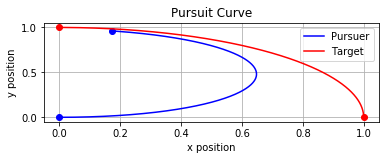

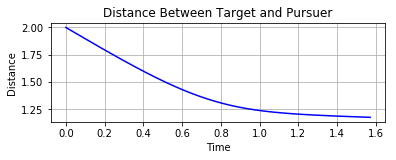

0:00:06.945207


In [22]:
# pi / 2

from datetime import datetime
startTime = datetime.now()
import numpy as np
import matplotlib.pyplot as plt
import sys
import random
import operator
from pyspark import SparkConf, SparkContext

#conf = SparkConf().setAppName("euler")
#sc = SparkContext(conf=conf)
assert sc.version >= '1.5.1'

def ForwardEuler(deltaT, P0, k, Tprime_rdd, Tarray_rdd):     
    x = np.zeros(N)
    y = np.zeros(N)
    x[0] = P0[0]
    y[0] = P0[1]

    for i in range(N-1):
        x[i+1] = x[i] + deltaT*(((k*np.sqrt((Tprime_rdd[i][0][0])**2 + (Tprime_rdd[i][0][1])**2))/ np.sqrt((Tarray_rdd[i][0][0]-x[i])**2 + (Tarray_rdd[i][0][1]-y[i])**2)) * (Tarray_rdd[i][0][0]-x[i]))
        TprimeNorm = k*np.sqrt((Tprime_rdd[i][0][0])**2 + (Tprime_rdd[i][0][1])**2)
        b = np.sqrt((Tarray_rdd[i][0][0]-x[i])**2 + (Tarray_rdd[i][0][1]-y[i])**2)
        y[i+1] = y[i] + deltaT*((TprimeNorm/b)*(Tarray_rdd[i][0][1]-y[i]))
        
    P = np.vstack((x,y)) 
    return (t, P) 

def T(t):
    Tx = np.cos(t) 
    Ty = np.sin(t)  
    return np.array([Tx, Ty]) 


def Tprime(t):   
    First = T(t+0.000001)
    Second = T(t)
    Tp = (First-Second)/0.000001
    return Tp


def Plot(PX, PY, Tx1, Ty1, Distance, tFE):
#Part b: Pursuit Curve
    plt.figure(1)
    plt.subplot(211)
    plt.plot(PX, PY, 'b', label='Pursuer')  
    plt.plot(PX[0], PY[0], 'bo-', PX[-1], PY[-1], 'bo-')    
    plt.plot(Tx1, Ty1, 'r', label='Target')  
    plt.plot(Tx1[0], Ty1[0], 'ro-', Tx1[-1], Ty1[-1], 'ro-')
    plt.title("Pursuit Curve")
    plt.xlabel('x position')
    plt.ylabel('y position')     
    plt.legend(loc=1)
    plt.grid()
    plt.show()

#Part c: Distance between
    plt.subplot(212)
    plt.plot(tFE, Distance, 'b')
    plt.title("Distance Between Target and Pursuer")
    plt.xlabel('Time')
    plt.ylabel('Distance')     
    plt.legend(loc=1)
    plt.grid()
    plt.show()

    
def FindK(tCatch, kInitialGuess, kUpperLimit, Distance):
    (k, deltaK) = np.linspace(kInitialGuess, kUpperLimit, 2000, retstep=True)
    k0 = k[0]
    Distance += 1    #Changes distance to force to recalculate k even if k from Part one works (used to optimize)
    while 10**(-4) <= Distance[-1]:  
        k0 += deltaK
        (TempT, TempY) = ForwardEuler(deltaT, P0, k0, Tprime_rdd[:][:][:], Tarray_rdd[:][:][:])
        PXtemp = TempY[0]
        PYtemp = TempY[1]
        Tpos = T(tCatch)
        Tx2 = Tpos[0]
        Ty2 = Tpos[1]
        Distance = np.sqrt((Tx2-PXtemp)**2 + (Ty2-PYtemp)**2)
        print('D = ',Distance)
    return k0

#Initial Conditions
P0 = [0, 0]
k = 1.03436718359       #use for part 1
tEnd = np.pi / 2           #Also tCatch for part 2
N = 10000

Tx1 = np.zeros(N)
Ty1 = np.zeros(N)
tCopy = np.linspace(0, tEnd, N)
tCopy_rdd = sc.parallelize(tCopy)

kInitialGuess = 1.2        #initial guess to cut down waiting time for part 2
kUpperLimit = 2             #Increase as needed if k never reaches less than 10^(-4)


#Calculate Target's position for plotting
Tpos = tCopy_rdd.map(T)
T_rdd = Tpos.zipWithIndex().collect()
for j in range (N):
    Tx1[j] = T_rdd[j][0][0]
    Ty1[j] = T_rdd[j][0][1]
    Target = np.vstack((Tx1,Ty1))
    #print(Tx1,Ty1)

    
(t, deltaT) = np.linspace(0, tEnd, N, retstep=True)
t_rdd = sc.parallelize(t)
Tarray = t_rdd.map(T)
Tarray_rdd = Tarray.zipWithIndex().collect()
TprimeArray = t_rdd.map(Tprime)
Tprime_rdd = TprimeArray.zipWithIndex().collect()


#Calculate Forward Euler
(tFE, yFE) = ForwardEuler(deltaT, P0, k, Tprime_rdd[:][:][:], Tarray_rdd[:][:][:])

PX = yFE[0]
PY = yFE[1]

#Calculate distance between Target and Pursuer
Distance = np.sqrt((Tx1-PX)**2 + (Ty1-PY)**2)

#Find Kcrit
k = FindK(tEnd, kInitialGuess, kUpperLimit, Distance)
print('catch kcrit = ',k)

#Plot Pursuit and Distance graphs
Plot(PX, PY, Tx1, Ty1, Distance, tFE)
print(datetime.now() - startTime)

D =  [ 1.          0.99991668  0.99983335 ...,  0.06761319  0.06749535
  0.06737751]
D =  [ 1.          0.99991666  0.99983333 ...,  0.06748982  0.06737196
  0.0672541 ]
D =  [ 1.          0.99991665  0.9998333  ...,  0.06736644  0.06724856
  0.06713068]
D =  [ 1.          0.99991664  0.99983327 ...,  0.06724307  0.06712517
  0.06700727]
D =  [ 1.          0.99991662  0.99983324 ...,  0.0671197   0.06700178
  0.06688386]
D =  [ 1.          0.99991661  0.99983322 ...,  0.06699634  0.0668784
  0.06676046]
D =  [ 1.          0.99991659  0.99983319 ...,  0.06687297  0.06675501
  0.06663705]
D =  [ 1.          0.99991658  0.99983316 ...,  0.06674961  0.06663163
  0.06651365]
D =  [ 1.          0.99991657  0.99983313 ...,  0.06662624  0.06650824
  0.06639025]
D =  [ 1.          0.99991655  0.9998331  ...,  0.06650288  0.06638486
  0.06626685]
D =  [ 1.          0.99991654  0.99983308 ...,  0.06637952  0.06626148
  0.06614345]
D =  [ 1.          0.99991652  0.99983305 ...,  0.06625616  0.0661

D =  [ 1.          0.9999153   0.9998306  ...,  0.05540251  0.05528273
  0.05516294]
D =  [ 1.          0.99991529  0.99983058 ...,  0.05527915  0.05515934
  0.05503954]
D =  [ 1.          0.99991527  0.99983055 ...,  0.05515579  0.05503596
  0.05491614]
D =  [ 1.          0.99991526  0.99983052 ...,  0.05503242  0.05491258
  0.05479273]
D =  [ 1.          0.99991525  0.99983049 ...,  0.05490905  0.05478919
  0.05466933]
D =  [ 1.          0.99991523  0.99983047 ...,  0.05478569  0.0546658
  0.05454592]
D =  [ 1.          0.99991522  0.99983044 ...,  0.05466232  0.05454241
  0.05442251]
D =  [ 1.          0.9999152   0.99983041 ...,  0.05453894  0.05441902
  0.0542991 ]
D =  [ 1.          0.99991519  0.99983038 ...,  0.05441557  0.05429563
  0.05417568]
D =  [ 1.          0.99991518  0.99983035 ...,  0.05429219  0.05417223
  0.05405227]
D =  [ 1.          0.99991516  0.99983033 ...,  0.05416882  0.05404883
  0.05392885]
D =  [ 1.          0.99991515  0.9998303  ...,  0.05404544  0.0539

D =  [ 1.          0.99991393  0.99982785 ...,  0.04317579  0.04305406
  0.04293233]
D =  [ 1.          0.99991391  0.99982783 ...,  0.04305208  0.04293033
  0.04280858]
D =  [ 1.          0.9999139   0.9998278  ...,  0.04292836  0.04280659
  0.04268482]
D =  [ 1.          0.99991389  0.99982777 ...,  0.04280464  0.04268285
  0.04256106]
D =  [ 1.          0.99991387  0.99982774 ...,  0.04268092  0.04255911
  0.0424373 ]
D =  [ 1.          0.99991386  0.99982772 ...,  0.04255718  0.04243535
  0.04231352]
D =  [ 1.          0.99991384  0.99982769 ...,  0.04243344  0.0423116
  0.04218975]
D =  [ 1.          0.99991383  0.99982766 ...,  0.0423097   0.04218783
  0.04206596]
D =  [ 1.          0.99991382  0.99982763 ...,  0.04218595  0.04206406
  0.04194217]
D =  [ 1.          0.9999138   0.9998276  ...,  0.04206219  0.04194029
  0.04181838]
D =  [ 1.          0.99991379  0.99982758 ...,  0.04193843  0.04181651
  0.04169458]
D =  [ 1.          0.99991377  0.99982755 ...,  0.04181467  0.0416

  0.03077203]
D =  [ 1.          0.99991255  0.9998251  ...,  0.03089489  0.03077121
  0.03064754]
D =  [ 1.          0.99991254  0.99982508 ...,  0.03077042  0.03064673
  0.03052303]
D =  [ 1.          0.99991252  0.99982505 ...,  0.03064594  0.03052223
  0.03039851]
D =  [ 1.          0.99991251  0.99982502 ...,  0.03052146  0.03039772
  0.03027398]
D =  [ 1.          0.9999125   0.99982499 ...,  0.03039696  0.0302732
  0.03014945]
D =  [ 1.          0.99991248  0.99982496 ...,  0.03027245  0.03014867
  0.0300249 ]
D =  [ 1.          0.99991247  0.99982494 ...,  0.03014793  0.03002414
  0.02990034]
D =  [ 1.          0.99991245  0.99982491 ...,  0.0300234   0.02989959
  0.02977578]
D =  [ 1.          0.99991244  0.99982488 ...,  0.02989886  0.02977503
  0.0296512 ]
D =  [ 1.          0.99991243  0.99982485 ...,  0.02977432  0.02965046
  0.02952661]
D =  [ 1.          0.99991241  0.99982483 ...,  0.02964976  0.02952588
  0.02940201]
D =  [ 1.          0.9999124   0.9998248  ...,  0.02

  0.01839169]
D =  [ 1.          0.99991118  0.99982235 ...,  0.01851724  0.01839161
  0.01826599]
D =  [ 1.          0.99991116  0.99982233 ...,  0.01839156  0.01826592
  0.01814028]
D =  [ 1.          0.99991115  0.9998223  ...,  0.01826587  0.01814021
  0.01801455]
D =  [ 1.          0.99991113  0.99982227 ...,  0.01814017  0.01801449
  0.01788881]
D =  [ 1.          0.99991112  0.99982224 ...,  0.01801445  0.01788875
  0.01776305]
D =  [ 1.          0.99991111  0.99982221 ...,  0.01788872  0.017763    0.01763728]
D =  [ 1.          0.99991109  0.99982219 ...,  0.01776297  0.01763723
  0.01751149]
D =  [ 1.          0.99991108  0.99982216 ...,  0.0176372   0.01751145
  0.01738569]
D =  [ 1.          0.99991107  0.99982213 ...,  0.01751143  0.01738565
  0.01725987]
D =  [ 1.          0.99991105  0.9998221  ...,  0.01738563  0.01725984
  0.01713404]
D =  [ 1.          0.99991104  0.99982208 ...,  0.01725983  0.01713401
  0.01700819]
D =  [ 1.          0.99991102  0.99982205 ...,  0.01

D =  [ 1.          0.9999098   0.9998196  ...,  0.00599739  0.00586982
  0.00574226]
D =  [ 1.          0.99990979  0.99981958 ...,  0.00587005  0.00574246
  0.00561488]
D =  [ 1.          0.99990977  0.99981955 ...,  0.00574269  0.00561508
  0.00548747]
D =  [ 1.          0.99990976  0.99981952 ...,  0.0056153   0.00548768
  0.00536005]
D =  [ 1.          0.99990975  0.99981949 ...,  0.0054879   0.00536026
  0.00523261]
D =  [ 1.          0.99990973  0.99981946 ...,  0.00536049  0.00523282
  0.00510516]
D =  [ 1.          0.99990972  0.99981944 ...,  0.00523305  0.00510536
  0.00497768]
D =  [ 1.          0.9999097   0.99981941 ...,  0.00510559  0.00497789
  0.00485018]
D =  [ 1.          0.99990969  0.99981938 ...,  0.00497811  0.00485039
  0.00472267]
D =  [ 1.          0.99990968  0.99981935 ...,  0.00485062  0.00472287
  0.00459513]
D =  [ 1.          0.99990966  0.99981933 ...,  0.0047231   0.00459534
  0.00446757]
D =  [ 1.          0.99990965  0.9998193  ...,  0.00459557  0.004

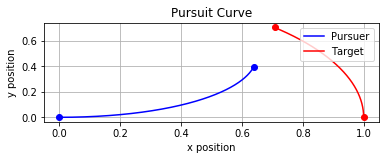

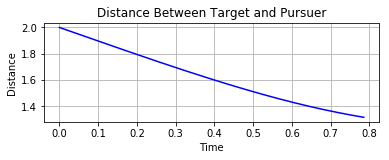

0:00:51.141618


In [28]:
# pi / 4

from datetime import datetime
startTime = datetime.now()
import numpy as np
import matplotlib.pyplot as plt
import sys
import random
import operator
from pyspark import SparkConf, SparkContext

#conf = SparkConf().setAppName("euler")
#sc = SparkContext(conf=conf)
assert sc.version >= '1.5.1'

def ForwardEuler(deltaT, P0, k, Tprime_rdd, Tarray_rdd):     
    x = np.zeros(N)
    y = np.zeros(N)
    x[0] = P0[0]
    y[0] = P0[1]

    for i in range(N-1):
        x[i+1] = x[i] + deltaT*(((k*np.sqrt((Tprime_rdd[i][0][0])**2 + (Tprime_rdd[i][0][1])**2))/ np.sqrt((Tarray_rdd[i][0][0]-x[i])**2 + (Tarray_rdd[i][0][1]-y[i])**2)) * (Tarray_rdd[i][0][0]-x[i]))
        TprimeNorm = k*np.sqrt((Tprime_rdd[i][0][0])**2 + (Tprime_rdd[i][0][1])**2)
        b = np.sqrt((Tarray_rdd[i][0][0]-x[i])**2 + (Tarray_rdd[i][0][1]-y[i])**2)
        y[i+1] = y[i] + deltaT*((TprimeNorm/b)*(Tarray_rdd[i][0][1]-y[i]))
        
    P = np.vstack((x,y)) 
    return (t, P) 

def T(t):
    Tx = np.cos(t) 
    Ty = np.sin(t)  
    return np.array([Tx, Ty]) 


def Tprime(t):   
    First = T(t+0.000001)
    Second = T(t)
    Tp = (First-Second)/0.000001
    return Tp


def Plot(PX, PY, Tx1, Ty1, Distance, tFE):
#Part b: Pursuit Curve
    plt.figure(1)
    plt.subplot(211)
    plt.plot(PX, PY, 'b', label='Pursuer')  
    plt.plot(PX[0], PY[0], 'bo-', PX[-1], PY[-1], 'bo-')    
    plt.plot(Tx1, Ty1, 'r', label='Target')  
    plt.plot(Tx1[0], Ty1[0], 'ro-', Tx1[-1], Ty1[-1], 'ro-')
    plt.title("Pursuit Curve")
    plt.xlabel('x position')
    plt.ylabel('y position')     
    plt.legend(loc=1)
    plt.grid()
    plt.show()

#Part c: Distance between
    plt.subplot(212)
    plt.plot(tFE, Distance, 'b')
    plt.title("Distance Between Target and Pursuer")
    plt.xlabel('Time')
    plt.ylabel('Distance')     
    plt.legend(loc=1)
    plt.grid()
    plt.show()

    
def FindK(tCatch, kInitialGuess, kUpperLimit, Distance):
    (k, deltaK) = np.linspace(kInitialGuess, kUpperLimit, 2000, retstep=True)
    k0 = k[0]
    Distance += 1    #Changes distance to force to recalculate k even if k from Part one works (used to optimize)
    while 10**(-4) <= Distance[-1]:  
        k0 += deltaK
        (TempT, TempY) = ForwardEuler(deltaT, P0, k0, Tprime_rdd[:][:][:], Tarray_rdd[:][:][:])
        PXtemp = TempY[0]
        PYtemp = TempY[1]
        Tpos = T(tCatch)
        Tx2 = Tpos[0]
        Ty2 = Tpos[1]
        Distance = np.sqrt((Tx2-PXtemp)**2 + (Ty2-PYtemp)**2)
        print('D = ',Distance)
    return k0

#Initial Conditions
P0 = [0, 0]
k = 1.03436718359       #use for part 1
tEnd = np.pi / 4        #Also tCatch for part 2
N = 10000

Tx1 = np.zeros(N)
Ty1 = np.zeros(N)
tCopy = np.linspace(0, tEnd, N)
tCopy_rdd = sc.parallelize(tCopy)

kInitialGuess = 1.5        #initial guess to cut down waiting time for part 2
kUpperLimit = 2             #Increase as needed if k never reaches less than 10^(-4)


#Calculate Target's position for plotting
Tpos = tCopy_rdd.map(T)
T_rdd = Tpos.zipWithIndex().collect()
for j in range (N):
    Tx1[j] = T_rdd[j][0][0]
    Ty1[j] = T_rdd[j][0][1]
    Target = np.vstack((Tx1,Ty1))
    #print(Tx1,Ty1)

    
(t, deltaT) = np.linspace(0, tEnd, N, retstep=True)
t_rdd = sc.parallelize(t)
Tarray = t_rdd.map(T)
Tarray_rdd = Tarray.zipWithIndex().collect()
TprimeArray = t_rdd.map(Tprime)
Tprime_rdd = TprimeArray.zipWithIndex().collect()


#Calculate Forward Euler
(tFE, yFE) = ForwardEuler(deltaT, P0, k, Tprime_rdd[:][:][:], Tarray_rdd[:][:][:])

PX = yFE[0]
PY = yFE[1]

#Calculate distance between Target and Pursuer
Distance = np.sqrt((Tx1-PX)**2 + (Ty1-PY)**2)

#Find Kcrit
k = FindK(tEnd, kInitialGuess, kUpperLimit, Distance)
print('catch kcrit = ',k)

#Plot Pursuit and Distance graphs
Plot(PX, PY, Tx1, Ty1, Distance, tFE)
print(datetime.now() - startTime)